## ATAC + MULTIOME SUPPORTING CELLS

### Transcription factor motif enrichment with Seurat

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata

/opt/conda/envs/atac_env/lib/python3.8/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anndata2ri          1.0.6
backcall            0.2.0
cairo               1.20.0
cffi                1.14.4
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
highs_wrapper       NA
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.0
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
markupsafe          1.1.1
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.2
numpy               1.20.0
packaging           20.9
pandas              1.2.1
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_res

In [5]:
print(anndata2ri.__version__)
print(anndata.__version__)

1.0.6
0.7.5


In [6]:
%load_ext rpy2.ipython

In [7]:
%%R

library(Signac)
library(Seurat)
library(SeuratDisk)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(BSgenome.Hsapiens.UCSC.hg38)
library(ensembldb)
library(JASPAR2018)
library(TFBSTools)
library(patchwork)
library(universalmotif)
library(MotifDb)
library(TFBSTools)
library(patchwork)
library(chromVAR)
library(motifmatchr)

For future reference most packages were installed here: */tmp/RtmpGjkK1o/downloaded_packages/*

**Set directories**

In [8]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/supporting_apr2021/"
experiment_prefix = 'supporting_'

**Load databases of position frequency matrices**

In [44]:
%%R -o pfm

# Get a list of motif position frequency matrices from the JASPAR, HOCOMOCO, HOMER and SwissRegulon databases
pfm <- getMatrixSet(
  x = JASPAR2018,
  opts = list(species = 9606, all_versions = FALSE)
)

tf_motif_hoco=subset(MotifDb, organism=='Hsapiens' & dataSource=='HOCOMOCOv10')
pfmHoco = convert_motifs(tf_motif_hoco, 'TFBSTools-PWMatrix')
pfmHoco_names =  sapply(pfmHoco, function(x) x@ID)
names(tf_motif_hoco) = pfmHoco_names
for (i in 1:length(pfmHoco) ){
    # Convert into a PCM
    x = t(pfmHoco[[i]]@profileMatrix) - apply(pfmHoco[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHoco[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHoco[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmHoco_names[i]]] <- pfmHoco[[i]]
}
# add data from SwissRegulon                       
tf_motif_SwissRegulon=subset(MotifDb, organism=='Hsapiens' & dataSource=='SwissRegulon')
pfmSwissRegulon = convert_motifs(tf_motif_SwissRegulon, 'TFBSTools-PWMatrix')
pfmSwissRegulon_names =  sapply(pfmSwissRegulon, function(x) x@ID)
names(tf_motif_SwissRegulon) = pfmSwissRegulon_names
for (i in 1:length(pfmSwissRegulon) ){
    # Convert into a PCM
    x = t(pfmSwissRegulon[[i]]@profileMatrix) - apply(pfmSwissRegulon[[i]]@profileMatrix, 2, min) # normalize per column
    pfmSwissRegulon[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmSwissRegulon[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmSwissRegulon_names[i]]] <- pfmSwissRegulon[[i]]
}


# add data from HOMER                       
tf_motif_HOMER=subset(MotifDb, dataSource=='HOMER')
pfmHOMER = convert_motifs(tf_motif_HOMER, 'TFBSTools-PWMatrix')
pfmHOMER_names =  sapply(pfmHOMER, function(x) x@ID)
names(pfmHOMER) = paste0( sapply( strsplit(pfmHOMER_names, '\\('), head, 1), '.HOMER')
#print(names(pfmHOMER))
names(pfmHOMER)[93] = "FOXL2.HOMER"
 
pfmHOMER = pfmHOMER[ grep('[a-z]',  names(pfmHOMER), invert = T) ] # remove non-human (lowercase)
print(names(pfmHOMER))

for (i in 1:length(pfmHOMER) ){
    # Convert into a PCM
    x = t(pfmHOMER[[i]]@profileMatrix) - apply(pfmHOMER[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHOMER[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHOMER[[i]]@profileMatrix) <- 'integer'
    pfmHOMER[[i]]@name = gsub('.HOMER', '', names(pfmHOMER)[i])
    pfm[[names(pfmHOMER)[i]]] <- pfmHOMER[[i]]
}


# Add name in id
idx =  grep('^MA', names(pfm) )
for (i in idx ){
    pfm[[i]]@ID = paste0(pfm[[i]]@name, '.', pfm[[i]]@ID)
    names(pfm)[i] = pfm[[i]]@ID
}

# remove pcm with NAs
pfm = pfm[ ! sapply(pfm, function(x) any(is.na(x@profileMatrix))) ]

length(pfm)
table(unlist(sapply(pfm, function(x) x@tags$dataSource)))

  [1] "AP-1.HOMER"                "FOXA1:AR.HOMER"           
  [3] "ARE.HOMER"                 "IRF:BATF.HOMER"           
  [5] "BATF.HOMER"                "BMAL1.HOMER"              
  [7] "BMYB.HOMER"                "BORIS.HOMER"              
  [9] "CDX4.HOMER"                "CEBP:AP1.HOMER"           
 [11] "CEBP:CEBP.HOMER"           "CEBP.HOMER"               
 [13] "CHR.HOMER"                 "CLOCK.HOMER"              
 [15] "COUP-TFII.HOMER"           "CRE.HOMER"                
 [17] "CRX.HOMER"                 "CTCF.HOMER"               
 [19] "DMRT1.HOMER"               "DMRT6.HOMER"              
 [21] "RAR:RXR.HOMER"             "RAR:RXR.HOMER"            
 [23] "E2A.HOMER"                 "E2F1.HOMER"               
 [25] "E2F4.HOMER"                "E2F6.HOMER"               
 [27] "E2F7.HOMER"                "E2F.HOMER"                
 [29] "E2A.HOMER"                 "EBF.HOMER"                
 [31] "EBF1.HOMER"                "EBNA1.HOMER"              
 [33] "E

In [45]:
pfm

<rpy2.robjects.methods.RS4 object at 0x7f04415d8740> [RTYPES.S4SXP]
R classes: ('PFMatrixList',)

#### Convert the h5ad created with cisTopic into a Seurat object with peaks assay

In [9]:
ATAC_scanpy = sc.read_h5ad(outdir + experiment_prefix + "_harmony_ATAC.wCisTopic.h5ad")
ATAC_scanpy

AnnData object with n_obs × n_vars = 33909 × 170503
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0_75', 'preGC_II', 'sLGR5', 'ovarianSurf', 'preGC_III', 'preGC_II_hypoxia', 'preGC_I_OSR1', 'sPAX8', 'preGC_III_Notch', 'sKITLG', 'coelEpi', 'Sertoli', 'Sertoli_WFDC2', 'FetalLeydig-like', 'max', 'sPAX8b', 'sPAX8m', 'leiden', 'leiden_R', 'cell_type', 'sex_clusters', 'new_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'cellatac_clusters_colors', 'individual_colors', 'leiden', 'leiden_R_color

In [12]:
ATAC_scanpy.X

<33909x170503 sparse matrix of type '<class 'numpy.float32'>'
	with 173907869 stored elements in Compressed Sparse Row format>

In [13]:
binary_raw = ATAC_scanpy.layers['binary_raw']
binary_raw

<33909x170503 sparse matrix of type '<class 'numpy.float32'>'
	with 173907869 stored elements in Compressed Sparse Row format>

In [14]:
binary_raw.shape

(33909, 170503)

Step 1: from sparse matrix (python format) to dgcMatrix (R format)

I found this function here: <https://github.com/theislab/anndata2ri/issues/8>

In [15]:
import numpy as np
from scipy import sparse

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.conversion import localconverter

ro.r("library(Matrix)")

def csr_to_dgc(csr):
    """Convert (and transpose) a csr matrix from python to a R dgCMatrix (not sure if type is consistent)
    """
    numeric = ro.r("as.numeric")
    with localconverter(ro.default_converter + ro.numpy2ri.converter):
        X = ro.r("sparseMatrix")(
            i=numeric(csr.indices),
            p=numeric(csr.indptr),
            x=numeric(csr.data),
            dims=list(csr.shape[::-1]),
            index1=False
        )
    return X

In [16]:
ATAC_R = csr_to_dgc(binary_raw)
ATAC_R

<rpy2.robjects.methods.RS4 object at 0x7fced7ad8500> [RTYPES.S4SXP]
R classes: ('dgCMatrix',)

In [17]:
%%R -i ATAC_R -o ATAC_dgT

ATAC_dgT <- as(ATAC_R, "dgTMatrix")
print(dim(ATAC_dgT)) # Check the shape of the matrix 

[1] 170503  33909


Step 2: save metadata per cell and per peak and add colnames and rownames to the peak matrix

In [19]:
metadata_cell = ATAC_scanpy.obs
metadata_peak = ATAC_scanpy.var
layers = ATAC_scanpy.layers
reduction_cistopic = ATAC_scanpy.obsm['X_cistopic_30']
reduction_umap = ATAC_scanpy.obsm['X_umap']
reduction_harmony = ATAC_scanpy.obsm['X_harmony']

In [20]:
del ATAC_scanpy.obs['cellatac_clusters']

In [21]:
%%R -i ATAC_dgT -i metadata_cell -i metadata_peak 

rownames(ATAC_dgT) <- rownames(metadata_peak) # Add rownames to peak matrix
colnames(ATAC_dgT) <- rownames(metadata_cell) # Add colnames to peak matrix 

In [22]:
%%R 
print(head(rownames(ATAC_dgT)))
print(head(colnames(ATAC_dgT)))
print(names(ATAC_dgT))

[1] "chr1:816745-817421" "chr1:825662-826063" "chr1:826598-827809"
[4] "chr1:868837-869161" "chr1:869380-870256" "chr1:875184-875947"
[1] "01-AAACGAAAGGCTCCTG-1" "01-AAACGAAAGTCCAGAG-1" "01-AAACGAACACCCATCT-1"
[4] "01-AAACGAACAGGTCTGC-1" "01-AAACGAAGTAGGGTCA-1" "01-AAACGAAGTATTGTCG-1"
NULL


Step 3: build ChromatinAssay with peaks x cells matrix 

In [23]:
%%R -o chrom_assay 

 chrom_assay <- CreateChromatinAssay(
    counts = ATAC_dgT,
    sep = c(":", "-"),
    genome = "hg38",
    ranges = NULL,
 )
chrom_assay

ChromatinAssay data with 170503 features for 33909 cells
Variable features: 0 
Genome: hg38 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 0 


Step 4: build Seurat object from chromatin assay 

In [24]:
%%R -o ATAC_Seurat -i metadata_cell

ATAC_Seurat <- CreateSeuratObject(
    counts = chrom_assay,
    assay = "peaks",
    meta.data = metadata_cell,
  )
ATAC_Seurat

An object of class Seurat 
170503 features across 33909 samples within 1 assay 
Active assay: peaks (170503 features, 0 variable features)


In [25]:
%%R 
print(table(ATAC_Seurat@meta.data$individual))
print(table(ATAC_Seurat@meta.data$leiden))


  F81  Hrv3 Hrv10 Hrv11 Hrv12 Hrv13 Hrv15 Hrv17 Hrv18 Hrv21 Hrv39 Hrv40 Hrv49 
 6600   364   726   219  1032  2399  1939  1821  1357  1736  3132  2413  3526 
Hrv50 Hrv58 Hrv59 
 5174   449  1022 

   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
5574 4743 4227 3620 3161 3104 1756 1331 1108  980  909  857  776  774  752  112 
  16   17 
  87   38 


Step 5: Add dimensionality reductions to Seurat object 

In [26]:
%%R -i reduction_cistopic -i metadata_cell -o reduction_cistopic_2 

reduction_cistopic_2 <- data.matrix(reduction_cistopic)
key <- "cisTopic_"
colnames(reduction_cistopic_2) <- paste0(key, 1:ncol(x = reduction_cistopic_2))
rownames(reduction_cistopic_2) <- rownames(metadata_cell)
#print(head(reduction_cistopic_2))

In [27]:
%%R -i reduction_umap -i metadata_cell -o reduction_umap_2 

reduction_umap_2 <- data.matrix(reduction_umap)
key2 <- "UMAP_"
colnames(reduction_umap_2) <- paste0(key2, 1:ncol(x = reduction_umap_2))
rownames(reduction_umap_2) <- rownames(metadata_cell)
#print(head(reduction_umap_2))

In [28]:
%%R -i reduction_harmony -i metadata_cell -o reduction_harmony_2 

reduction_harmony_2 <- data.matrix(reduction_harmony)
key3 <- "Harmony_"
colnames(reduction_harmony_2) <- paste0(key3, 1:ncol(x = reduction_harmony_2))
rownames(reduction_harmony_2) <- rownames(metadata_cell)
#print(head(reduction_harmony_2))

In [29]:
%%R 

ATAC_Seurat@reductions$cisTopics <- CreateDimReducObject(embeddings = reduction_cistopic_2, assay = "peaks")
ATAC_Seurat@reductions$umap <- CreateDimReducObject(embeddings = reduction_umap_2, assay = "peaks")
ATAC_Seurat@reductions$harmony <- CreateDimReducObject(embeddings = reduction_harmony_2, assay = "peaks")
ATAC_Seurat

An object of class Seurat 
170503 features across 33909 samples within 1 assay 
Active assay: peaks (170503 features, 0 variable features)
 3 dimensional reductions calculated: cisTopics, umap, harmony


In [30]:
%%R
ATAC_Seurat@reductions$umap

A dimensional reduction object with key UMAP_ 
 Number of dimensions: 2 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: peaks 


In [32]:
%%R
ATAC_Seurat@reductions$cisTopics

A dimensional reduction object with key cisTopic_ 
 Number of dimensions: 30 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: peaks 


#### Add motifs

In [33]:
%%R -o ATAC_Seurat_withMotifs

ATAC_Seurat_withMotifs <- AddMotifs(object = ATAC_Seurat, 
                         genome= BSgenome.Hsapiens.UCSC.hg38, 
                         pfm = pfm, 
                         assay = "peaks", 
                         verbose = TRUE)

ATAC_Seurat_withMotifs

An object of class Seurat 
170503 features across 33909 samples within 1 assay 
Active assay: peaks (170503 features, 0 variable features)
 3 dimensional reductions calculated: cisTopics, umap, harmony


#### Compute a per-cell motif activity scores with chromVar

In [34]:
%%R -o ATAC_Seurat_withChromVar

library(BiocParallel)
register(SerialParam())
ATAC_Seurat_withChromVar <- RunChromVAR(
  object = ATAC_Seurat_withMotifs,
  genome = BSgenome.Hsapiens.UCSC.hg38,
  assay="peaks"
)
ATAC_Seurat_withChromVar

An object of class Seurat 
172423 features across 33909 samples within 2 assays 
Active assay: peaks (170503 features, 0 variable features)
 1 other assay present: chromvar
 3 dimensional reductions calculated: cisTopics, umap, harmony


Intermediate saving just in case 

In [35]:
%%R -i outdir -i experiment_prefix

saveRDS(ATAC_Seurat_withChromVar, file = paste0(outdir, experiment_prefix, "_chromVar_binary.rds"))

In [38]:
%%R -i outdir -i experiment_prefix

ATAC_Seurat_withChromVar = readRDS(paste0(outdir, experiment_prefix, "_chromVar_binary.rds"))
ATAC_Seurat_withChromVar

An object of class Seurat 
172423 features across 33909 samples within 2 assays 
Active assay: peaks (170503 features, 0 variable features)
 1 other assay present: chromvar
 3 dimensional reductions calculated: cisTopics, umap, harmony


In [41]:
new_clusters = pd.read_csv(outdir + experiment_prefix + "new_clusters.csv", index_col = 0)

In [42]:
new_clusters.head()

,new_clusters
01-AAACGAAAGGCTCCTG-1,preGC_I_OSR1
01-AAACGAAAGTCCAGAG-1,sLGR5_female
01-AAACGAACACCCATCT-1,ovarianSurf
01-AAACGAACAGGTCTGC-1,preGC_I_OSR1
01-AAACGAAGTAGGGTCA-1,preGC_I_OSR1


In [43]:
%%R -i new_clusters

ATAC_Seurat_withChromVar@meta.data$new_clusters2 <- new_clusters$new_clusters

#### Test for differential accessibility scores between cell types 

In [46]:
%%R -i pfm -o motif2names

library(dplyr) 
motif2names <- lapply(pfm, function(x) x@name)
names(motif2names) <- sapply(pfm, function(x) x@ID) %>% gsub('_', '-', .)

In [47]:
%%R 

DefaultAssay(ATAC_Seurat_withChromVar) <- "chromvar" # Change default assay 

In [48]:
%%R 

Idents(ATAC_Seurat_withChromVar) <- ATAC_Seurat_withChromVar@meta.data$new_clusters2

In [49]:
%%R 

print(table(ATAC_Seurat_withChromVar@meta.data$new_clusters2))


         coelEpi FetalLeydig-like      ovarianSurf     preGC_I_OSR1 
            1331              864             3161             6625 
        preGC_II preGC_II_hypoxia  preGC_III_Notch          Sertoli 
            3880             4227             3620             7417 
          sKITLG     sLGR5_female       sLGR5_male           sPAX8b 
             436              979              474              627 
          sPAX8m 
             268 


In [50]:
%%R -i outdir -o all_da_peaks

all_da_peaks = FindAllMarkers(ATAC_Seurat_withChromVar, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0, return.thresh = 1)
write.csv(all_da_peaks, file = paste0(outdir, 'TFs/DARs/all_DA_peaks_LR_round2.csv'))

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~12m 52s       |++                                                | 2 % ~12m 11s       |++                                                | 3 % ~12m 01s       |+++                                               | 4 % ~11m 42s       |+++                                               | 5 % ~11m 08s       |++++                                              | 6 % ~10m 52s       |++++                                              | 7 % ~10m 40s       |+++++                                             | 8 % ~10m 21s       |+++++                                             | 9 % ~10m 07s       |++++++                                            | 10% ~10m 10s       |++++++                                            | 11% ~09m 59s       |+++++++                                           | 12% ~09m 50s       |+++++++                                           | 14% ~09m 

In [ ]:
%%R -i outdir -o da_peaks

# Generate GRanges object
GR = genes(EnsDb.Hsapiens.v86)

for( cl in rev(levels(Idents(ATAC_Seurat_withChromVar))) ){
    print(paste0("Comparing cluster ", cl, " with rest"))
    da_peaks = FindMarkers(ATAC_Seurat_withChromVar, ident.1 = cl, test.use = "LR", 
                           min.pct = 0.1, 
                           latent.vars = 'nCount_peaks', 
                           logfc.threshold = 0.1)
    write.csv(da_peaks, file = paste0(outdir, 'TFs/DARs/', cl, '_LR.csv'))
    print(paste0("Saved csv for cluster ", cl))
    #hist(da_peaks$avg_logFC, breaks = 100, main = paste0('cluster ', cl) )
}

**Find TFs of interest**

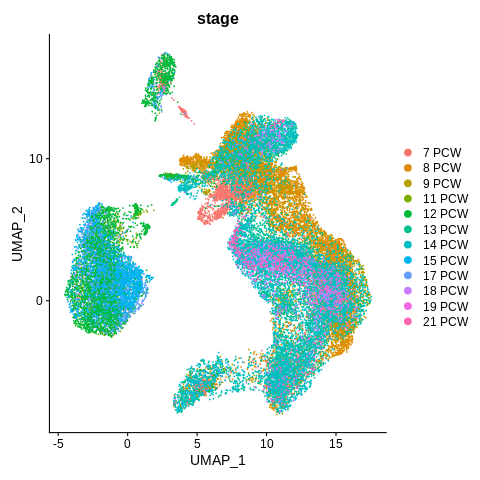

In [15]:
%%R 

DimPlot(object = ATAC_Seurat_withChromVar, group.by = "stage", pt.size = 0.2)

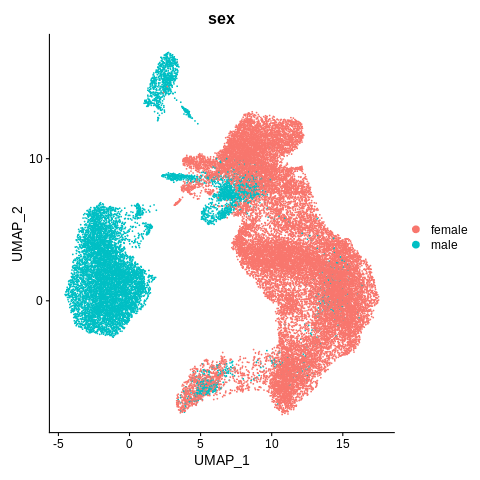

In [16]:
%%R 

DimPlot(object = ATAC_Seurat_withChromVar, group.by = "sex", pt.size = 0.2)

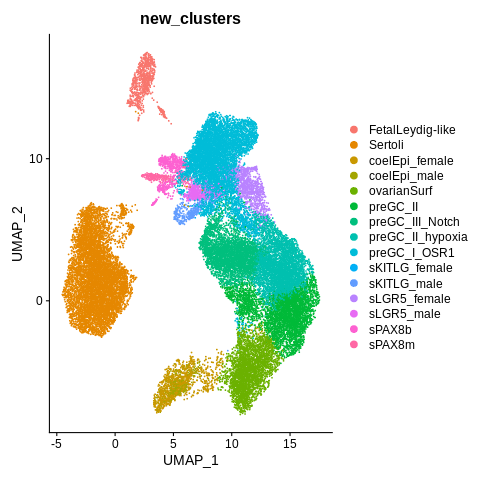

In [18]:
%%R 

DimPlot(object = ATAC_Seurat_withChromVar, group.by = "new_clusters", pt.size = 0.2)

#### Transcription Factor motif enrichemnt per leiden cluster

In [19]:
%%R 

ATAC_Seurat_withChromVar

An object of class Seurat 
172423 features across 33909 samples within 2 assays 
Active assay: chromvar (1920 features, 0 variable features)
 1 other assay present: peaks
 3 dimensional reductions calculated: cisTopics, umap, harmony


In [20]:
%%R -o chromvar_assay

chromvar_assay <- as.data.frame(t(x = as.matrix(x = GetAssayData(object = ATAC_Seurat_withChromVar))))

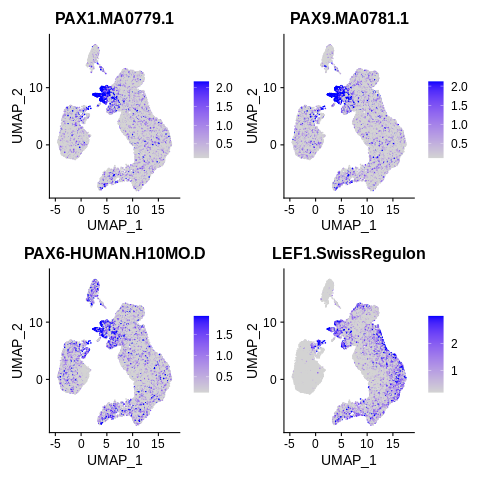

In [21]:
%%R 

FeaturePlot(
  object = ATAC_Seurat_withChromVar,
  features = c("PAX1.MA0779.1", "PAX9.MA0781.1", "PAX6-HUMAN.H10MO.D", "LEF1.SwissRegulon"),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)

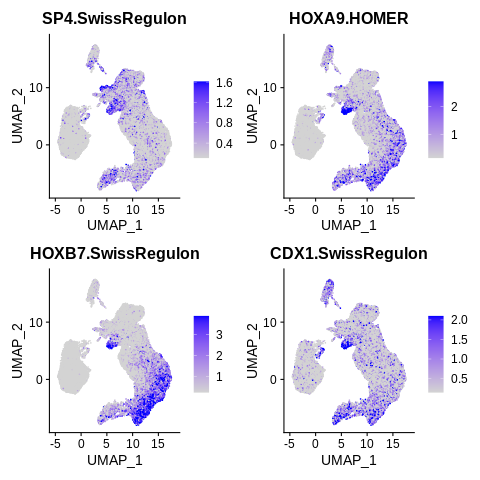

In [22]:
%%R 

FeaturePlot(
  object = ATAC_Seurat_withChromVar,
  features = c("SP4.SwissRegulon", "HOXA9.HOMER", "HOXB7.SwissRegulon", "CDX1.SwissRegulon"),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)

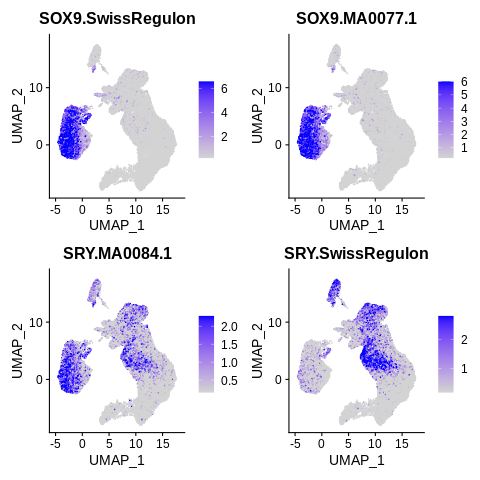

In [23]:
%%R 

FeaturePlot(
  object = ATAC_Seurat_withChromVar,
  features = c("SOX9.SwissRegulon", "SOX9.MA0077.1", "SRY.MA0084.1", "SRY.SwissRegulon"),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)

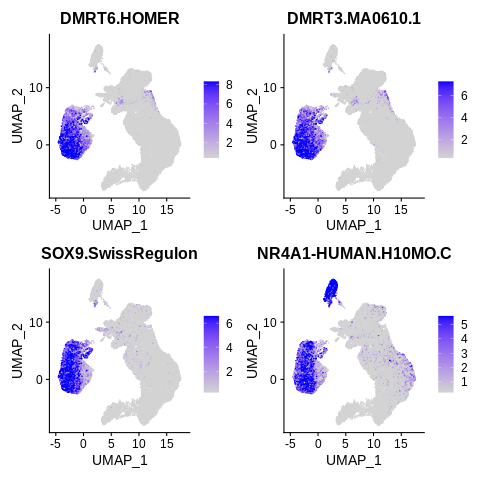

In [24]:
%%R 

FeaturePlot(
  object = ATAC_Seurat_withChromVar,
  features = c("DMRT6.HOMER", "DMRT3.MA0610.1", "SOX9.SwissRegulon", "NR4A1-HUMAN.H10MO.C"),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)

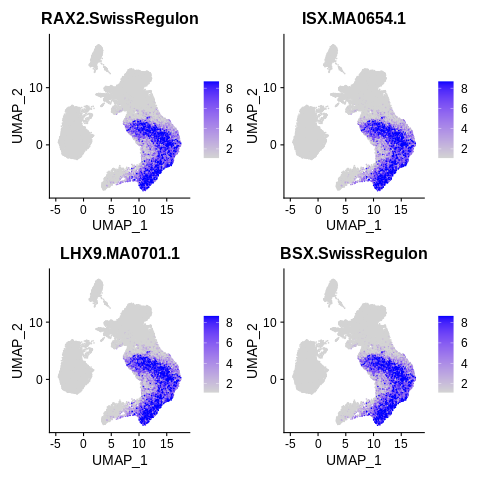

In [25]:
%%R 

FeaturePlot(
  object = ATAC_Seurat_withChromVar,
  features = c("RAX2.SwissRegulon", "ISX.MA0654.1", "LHX9.MA0701.1", "BSX.SwissRegulon"),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)

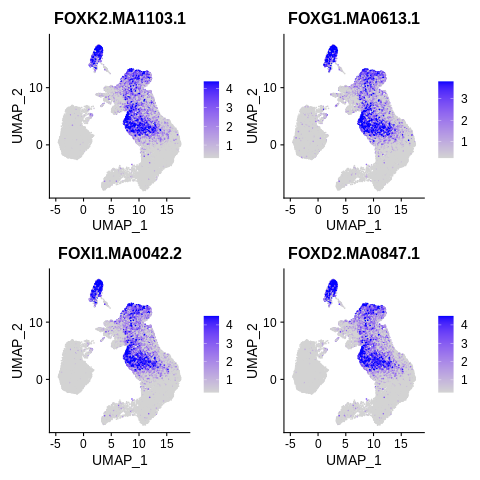

In [26]:
%%R 

FeaturePlot(
  object = ATAC_Seurat_withChromVar,
  features = c("FOXK2.MA1103.1", "FOXG1.MA0613.1", "FOXI1.MA0042.2", "FOXD2.MA0847.1"),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)

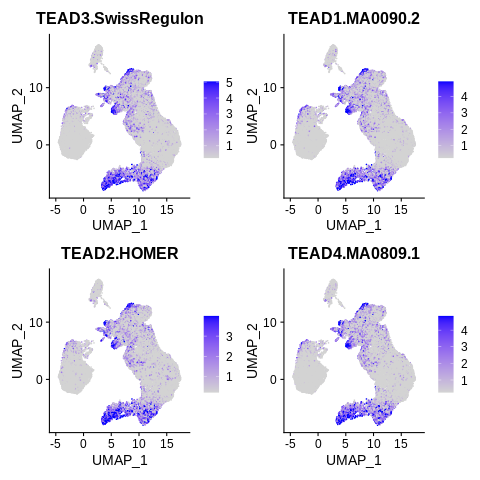

In [27]:
%%R 

FeaturePlot(
  object = ATAC_Seurat_withChromVar,
  features = c("TEAD3.SwissRegulon", "TEAD1.MA0090.2", "TEAD2.HOMER", "TEAD4.MA0809.1"),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)

In [55]:
ATAC_scanpy.obs[['individual', 'sex', 'stage']].value_counts().to_csv('/home/jovyan/ATAC_metadata.csv', index=True, header=True)

In [57]:
ATAC_scanpy.obs[['sample', 'sex', 'stage']].value_counts()

sample           sex     stage 
FCA_GND8046539   female  8 PCW     6600
HD_F_GON9479873  female  13 PCW    3526
HD_F_GON9479874  female  14 PCW    3135
HD_F_GON9479871  female  14 PCW    2955
HD_F_GON9479872  male    15 PCW    2413
FCA_GND8768485   female  9 PCW     2399
HD_F_GON9479875  female  14 PCW    2039
FCA_GND8795927   male    7 PCW     1821
FCA_GND9332157   male    17 PCW    1736
FCA_GND8795928   male    12 PCW    1357
FCA_GND8768484   female  8 PCW     1032
HD_F_GON9883959  female  18 PCW    1022
HD_F_GON9525612  male    12 PCW     946
HD_F_GON9525611  male    12 PCW     907
FCA_GND8768482   male    11 PCW     726
HD_F_GON9883960  female  21 PCW     449
FCA_GND8768481   male    19 PCW     364
FCA_GND8768483   female  14 PCW     219
HD_F_GON9525614  female  14 PCW     111
FCA_GND8768487   male    12 PCW      86
HD_F_GON9525613  female  14 PCW      66
dtype: int64

#### End of notebook